In this notebook we'll just run a quick computation to check the algebra in the notes for the marginal likelihood of the PL under a uniform prior.

In [1]:
source("../code/bplaw_aux.r")

In [2]:
library(poweRlaw)
data(moby)
thedata <- moby
#thedata <- sample(moby, 100)
power_law_raw <- displ$new(thedata) 
raw_est <- estimate_xmin(power_law_raw)

lognorm <- dislnorm$new(thedata)
ln_est <-  estimate_xmin(lognorm)

## lower threshold under both distributions
mm_pl <- raw_est$xmin 
mm_ln <- ln_est$xmin

mm_ln;mm_pl
mmin <- mm_pl
power_law_raw$setXmin(mmin)
lognorm$setXmin(mmin)

[1] 3

[1] 7

In [15]:
dat <- thedata[thedata > mmin]
dist.data <- list(
  N = length(dat),
  x = dat,
  x_min = mmin,
  lower_alpha = 1.5,
  upper_alpha = 3
)

In [16]:
library(rstan)
rstan_options(auto_write = TRUE)

In [17]:
### Power law
tPL.model <- stan_model(file = "../code/stan/power_law_fixedMin_uniformPrior.stan",
                       save_dso = TRUE)
posterior_tPL  <- sampling(tPL.model, data = dist.data, iter = 2000, refresh = 0)
posterior_tPL

Inference for Stan model: power_law_fixedMin_uniformPrior.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd      2.5%       25%       50%       75%     97.5%
alpha      1.90    0.00 0.02      1.86      1.89      1.90      1.91      1.93
lp__  -10827.79    0.02 0.72 -10829.76 -10827.93 -10827.52 -10827.34 -10827.29
      n_eff Rhat
alpha  1725    1
lp__   1411    1

Samples were drawn using NUTS(diag_e) at Tue Jan  8 17:14:57 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

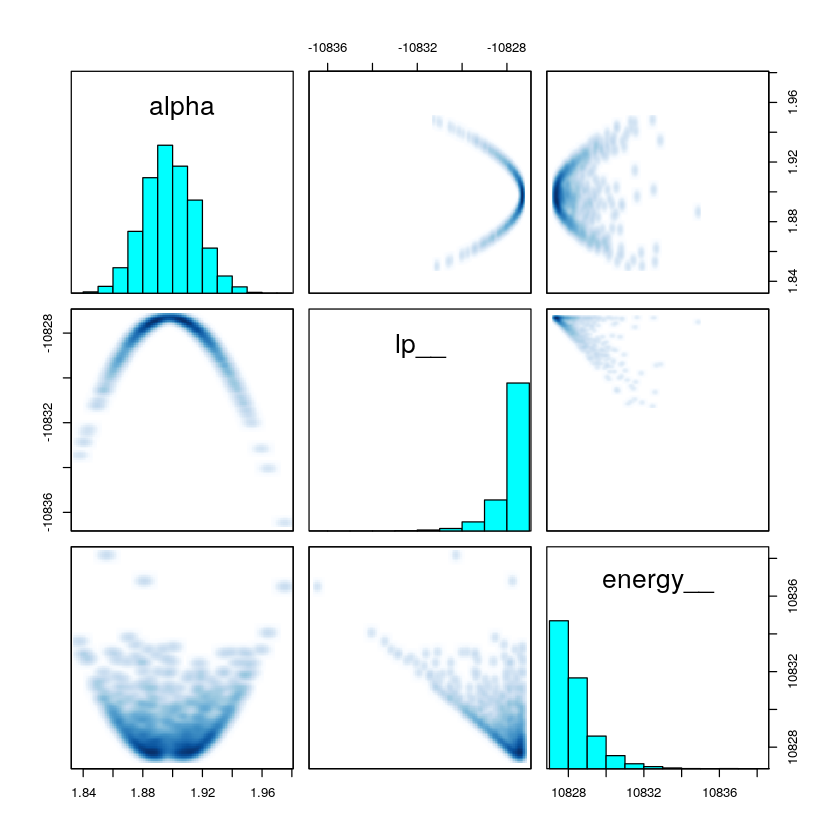

In [18]:
pairs(posterior_tPL)

In [19]:
library(bridgesampling)
summary( mal_est_tPL  <- bridgesampling::bridge_sampler(posterior_tPL) )

Warning message:
“effective sample size cannot be calculated, has been replaced by number of samples.”

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


Logml_Estimate,Relative_Mean_Squared_Error,Coefficient_of_Variation,Percentage_Error,Method,Repetitions
-10829.19,1.499081e-07,0.0003871797,0.0387%,normal,1


In [20]:
get_log_marg_lik_pwL_uniform <- function(x, m, l, u){
    if(l < 1) stop("Need l to be bigger than 1")
    if(u < l) stop("Upper bound u has to be strictly larger than lower bound l")
    if(any(x < m)) stop("Some of the observations are smaller than m")    
  ## returns the log-marginal likelihood under a power law model with a Uniform(l, u) prior on alpha
  w <- l-1
  y <- u-1
  N <- length(x)
  logProd <- sum(log(x))
  logZ <- N * log(m) - logProd
  ### 
  lNum <- logDiffExp(lgamma_inc(N + 1, -logZ * w), lgamma_inc(N + 1, -logZ * y))  
  lDenom <- log(u-l) + logProd +  N * log(-logZ) + log(-logZ)
  ans <- lNum - lDenom
  return(ans)      
}

In [27]:
cat("analytical: ", get_log_marg_lik_pwL_uniform(dist.data$x, dist.data$x_min,
                                                 l = dist.data$lower_alpha, u = dist.data$upper_alpha), "\n")
cat("Bridge sampling: ", mal_est_tPL$logml, "\n")

analytical:  -10829.18 
Bridge sampling:  -10829.19 


Let's now use [`lintegrate`](https://github.com/mattpitkin/lintegrate) to compute the quadrature, for good measure.

In [25]:
pld <- function(x, alpha, m, log = FALSE){
    dens <- log(alpha-1)-log(m) - alpha * (log(x) - log(m))
    ans <- sum(dens)
    return(ans)
} 
l <- 1.5
u <- 3
posterior <- function(a, args = c(0, 1)) pld(x = dist.data$x, alpha = a, m = dist.data$x_min) + dunif(a, l, u, log = TRUE)
require(reticulate)
  lint <- import("lintegrate", convert = FALSE)
  intt <- lint$lcquad(py_func(posterior), a=r_to_py(l), b=r_to_py(u),
                      args=c(1, 0), epsabs = r_to_py(1e-500))

In [26]:
intt

(-10829.184174134803, -5428.463520625864, 119971)